<a href="https://colab.research.google.com/github/caua-sathler/NEURAL-NETWORKS/blob/main/MLP-PSO-SGD/MLP_PSO_Adam_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 10/200, Loss: 0.61, Acc: 75.82
Epoch 20/200, Loss: 0.61, Acc: 80.22
Epoch 30/200, Loss: 0.66, Acc: 79.12
Epoch 40/200, Loss: 0.72, Acc: 76.92
Epoch 50/200, Loss: 0.75, Acc: 76.92
Epoch 60/200, Loss: 0.78, Acc: 80.22
Epoch 70/200, Loss: 0.83, Acc: 79.12
Epoch 80/200, Loss: 0.93, Acc: 80.22
Epoch 90/200, Loss: 0.96, Acc: 80.22
Epoch 100/200, Loss: 0.96, Acc: 79.12
Epoch 110/200, Loss: 0.96, Acc: 79.12
Epoch 120/200, Loss: 0.97, Acc: 79.12
Epoch 130/200, Loss: 0.98, Acc: 79.12
Epoch 140/200, Loss: 0.99, Acc: 79.12
Epoch 150/200, Loss: 1.00, Acc: 79.12
Epoch 160/200, Loss: 1.01, Acc: 79.12
Epoch 170/200, Loss: 1.02, Acc: 79.12
Epoch 180/200, Loss: 1.03, Acc: 79.12
Epoch 190/200, Loss: 1.04, Acc: 79.12
Epoch 200/200, Loss: 1.05, Acc: 79.12

Treinamento concluído!
Maior Acurácia Obtida: 81.32%


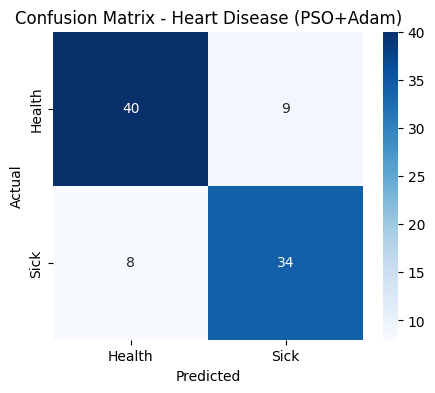

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

df = pd.read_csv(url, names=columns)
df.replace("?", float("nan"), inplace=True)
df = df.astype(float)
df.fillna(df.mean(), inplace=True)

# Converter target para binário (0=saudável, 1=doente)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Separar features (X) e rótulos (y)
X = df.drop(columns=['target']).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

class Particle:
    def __init__(self, model, device):
        self.model = copy.deepcopy(model).to(device)
        self.best_model = copy.deepcopy(model).to(device)

        low, high = -10.0, 10.0
        velocity_scale = 0.1

        self.position = {
            name: torch.rand_like(param).to(device)*(high - low)+low
            for name, param in model.named_parameters()
        }
        self.velocity = {
            name: torch.randn_like(param).to(device)*velocity_scale
            for name, param in model.named_parameters()
        }

        self.best_loss = float('inf')  # melhor perda local
        self.device = device

        self.optimizer = optim.Adam(self.model.parameters())

    def calculate_grad(self, x_train, y_train, criterion):
        self.model.train()
        self.optimizer.zero_grad()

        outputs = self.model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        # self.optimizer.step()

        # _, predicted = torch.max(outputs.data, 1)
        # acc = (predicted == y_train).sum().item() / len(x_train)
        # return loss.item(), acc*100

    def pso_sgd(self, global_best_model, inertia, c1, c2, lr, beta1, beta2, epsilon, m, v, t):
        for name, param in self.model.named_parameters():
            if param.grad is None:
                continue

            local_rand = random.random()
            global_rand = random.random()

            # Atualização da velocidade
            self.velocity[name] = (
                inertia*self.velocity[name]
                + c1*local_rand*(self.best_model.state_dict()[name].to(self.device) - param.data)
                + c2*global_rand*(global_best_model.state_dict()[name].to(self.device) - param.data)
            )

            # Atualizar posição
            self.position[name] = param.data + self.velocity[name]
            param.data = self.position[name]

            # Adam simplificado
            m[name] = m[name].to(param.device)
            v[name] = v[name].to(param.device)

            m[name] = beta1*m[name] + (1-beta1)*param.grad
            v[name] = beta2*v[name] + (1-beta2)*(param.grad**2)

            # Substituição final
            param.data -= lr * (m[name] / (torch.sqrt(v[name]) + epsilon))
            # param.data = self.position[name] - lr * param.grad


    def evaluate_weights(self, x, y, criterion):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(x)
            loss = criterion(outputs, y)
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == y).sum().item() / len(x)
        return loss.item(), acc*100


# Parâmetros do PSO
pop_size = 10
num_epochs = 200
inertia = 0.9
c1, c2 = 0.5, 0.9
learning_rate = 0.0003
beta1, beta2 = 0.5, 0.999
epsilon = 1e-8

model = MLP(input_dim=13, output_dim=2)

particles = [Particle(model, device) for _ in range(pop_size)]
global_best_model = copy.deepcopy(particles[0].model)
global_best_score = float('inf')

criterion = nn.CrossEntropyLoss()

m = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
v = {name: torch.zeros_like(param) for name, param in model.named_parameters()}

# Armazenar melhor acurácia
overall_global_best_accuracy = 0.0
overall_global_best_model = copy.deepcopy(global_best_model)

for epoch in range(num_epochs):
    # Ajustar inércia ao longo do tempo
    inertia = 0.9 - ((0.9 - 0.4)/num_epochs)*epoch

    for particle in particles:
        particle.model.train()
        particle.optimizer.zero_grad()

        # PSO+SGD
        particle.calculate_grad(X_train, y_train, criterion)
        particle.pso_sgd(global_best_model, inertia, c1, c2, learning_rate,
                         beta1, beta2, epsilon, m, v, epoch+1)
        val_loss, val_acc = particle.evaluate_weights(X_train, y_train, criterion)

        # Avaliar e atualizar local best (com base no loss)
        if val_loss < particle.best_loss:
            particle.best_loss = val_loss
            particle.best_model = copy.deepcopy(particle.model)

    # Determinar g-best (menor perda)
    best_particle = min(particles, key=lambda p: p.best_loss)
    if best_particle.best_loss < global_best_score:
        global_best_score = best_particle.best_loss
        global_best_model = copy.deepcopy(best_particle.best_model)

    # Acurácia do g-best no teste
    test_loss, test_acc = best_particle.evaluate_weights(X_test, y_test, criterion)

    # Verificar se essa acurácia é a maior de todas.
    if test_acc > overall_global_best_accuracy:
        overall_global_best_accuracy = test_acc
        overall_global_best_model = copy.deepcopy(best_particle.best_model)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {test_loss:.2f}, Acc: {test_acc:.2f}")

print("\nTreinamento concluído!")
print(f"Maior Acurácia Obtida: {overall_global_best_accuracy:.2f}%")

#Matriz de Confusão com o overall_global_best_model
overall_global_best_model.eval()
with torch.no_grad():
    outputs_test = overall_global_best_model(X_test) # O modelo utilizado nos testes é aquele cujo seus pesos apresentaram maior acurácia ao longo do treinamento.
    #Com PSO os pesos de maior acurácia não necessáriamente são os pesos da última época de treinamento.
    _, predicted_test = torch.max(outputs_test.data, 1)

conf_mat = confusion_matrix(y_test.numpy(), predicted_test.numpy())

plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Health", "Sick"], yticklabels=["Health", "Sick"])
plt.title("Confusion Matrix - Heart Disease (PSO+Adam)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
